In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

First we will import all the required libraries. We will disable TensorFlow's debugging logs by setting an environment variable TF_CPP_MIN_LOG_LEVEL to 2. 

In [2]:
# Importing the necessary libraries
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Disabling TensorFlow's debugging logs
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import seaborn as sns
from keras import callbacks
from sklearn.metrics import accuracy_score
from os import listdir
from os.path import isfile, join

Now, we will pre-process the dataset. 

In [3]:
# pipeline parameters
BATCH_SIZE = 32
IMG_SIZE = (256, 256)
PATH = '../input/face-mask-12k-images-dataset/Face Mask Dataset/'

Now, we will prepare the train,test and validation datasets. 

We will use TensorFlow's image_dataset_from_directory function to load the images from a directory in the PATH variable and create a TensorFlow Dataset object.
The batch_size and image_size arguments are specified to control the size of the batches of images and the dimensions of the images, respectively. The shuffle argument is set to True to shuffle the images each time the dataset is iterated through, which can help improve the performance of the model during training. Note: We are not shuffling the images in the test dataset because we don't need to. 

In [4]:
# train dataset
train_dir = os.path.join(PATH, 'Train')

train_ds = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            shuffle=True)
num_items = len(train_ds) * BATCH_SIZE
print("The exact number of items found is", num_items)

Found 10000 files belonging to 2 classes.
The exact number of items found is 10016


In [5]:
# validation dataset
validation_dir = os.path.join(PATH, 'Validation')

validation_ds = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            shuffle=True)
num_items = len(validation_ds) * BATCH_SIZE
print("The exact number of items found is", num_items)

Found 800 files belonging to 2 classes.
The exact number of items found is 800


In [6]:
# test dataset
test_dir = os.path.join(PATH, 'Test')

test_ds = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            shuffle=False)
num_items = len(test_ds) * BATCH_SIZE
print("The exact number of items found is", num_items)

Found 992 files belonging to 2 classes.
The exact number of items found is 992


We have an assumption that all the 3 of our datasets ie the train,test and validation have only 2 classes ie photos with mask and photos without mask.

Let us validate that.

In [7]:
class_names = train_ds.class_names
print(class_names)

['WithMask', 'WithoutMask']


In [8]:
class_names = validation_ds.class_names
print(class_names)

['WithMask', 'WithoutMask']


In [9]:
class_names = test_ds.class_names
print(class_names)

['WithMask', 'WithoutMask']


We can see that all the three of our datasets have the same two classes, so this validates our assumption. Now, we can proceed with training the model.

Before that we will visualise some of the images in the training,test and validation dataset.

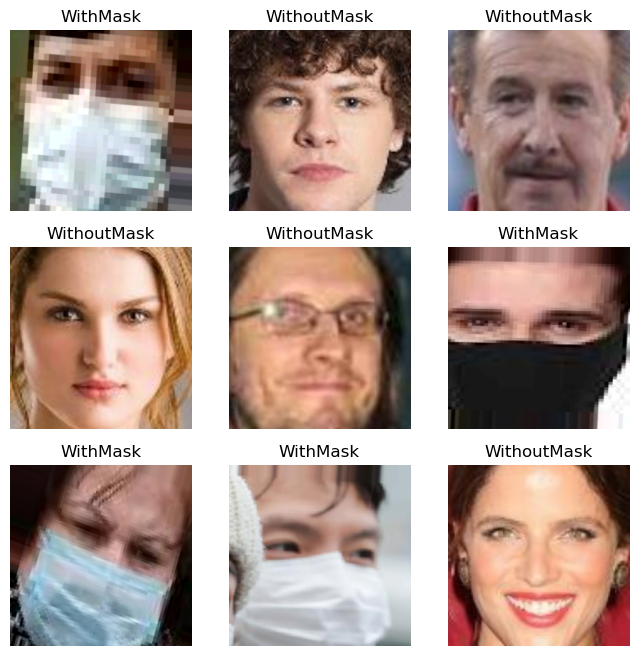

In [10]:
# data visualization on train
plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

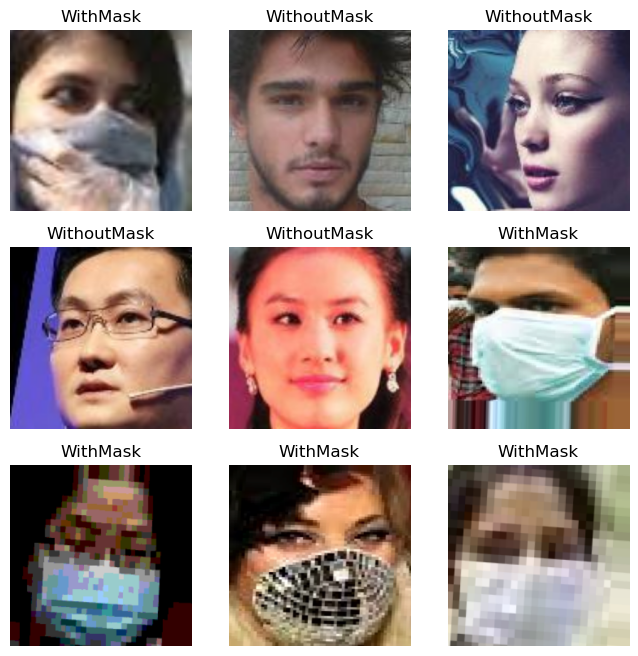

In [11]:
#Data Visualization of validation
plt.figure(figsize=(8, 8))
for images, labels in validation_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

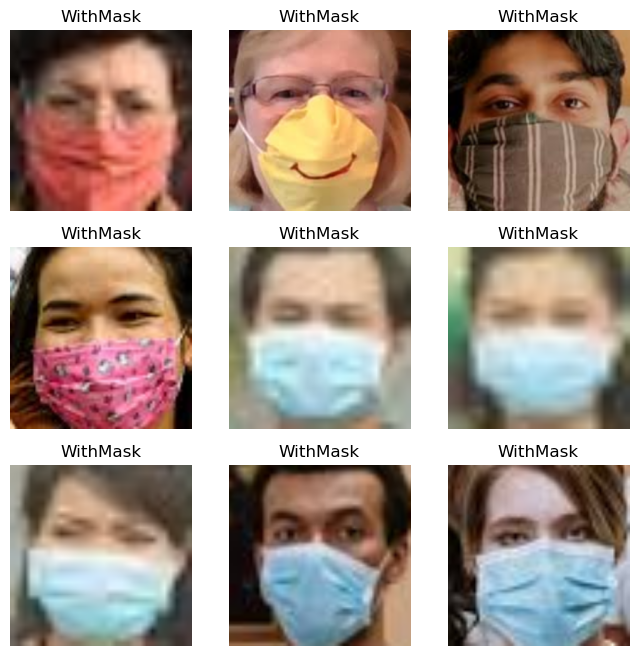

In [12]:
#Data Visualization of test
plt.figure(figsize=(8, 8))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Now, we will take steps to avoid I/O blocking, which can occur when the model is waiting for data to be loaded from disk or for preprocessing to complete. By caching the data and prefetching it in the background, we can keep the model fully utilized and avoid wasting time waiting for data. This will lead to faster training times and better performance.
We will set the AUTOTUNE variable to the value of tf.data.AUTOTUNE. This is a special value that can be passed as a buffer size to TensorFlow's Dataset methods, which will automatically tune the buffer size based on the available system resources and the characteristics of the data being processed.
The cache method caches the elements of the dataset in memory or on disk (depending on the size of the dataset) so that they don't have to be reloaded from disk each time they are accessed. This will significantly speed up the training process.
The prefetch method overlaps the preprocessing and model execution of the dataset, allowing the dataset to load and preprocess batches of data in the background while the model is executing on the previous batch. This will further improve the training speed, particularly when the preprocessing is slow.
The buffer_size argument passed to prefetch sets the size of the buffer used to prefetch the data. By setting it to AUTOTUNE, we allow TensorFlow to automatically tune the buffer size based on the available resources and the characteristics of the data being processed.

In [13]:
# autotune buffer to avoid I/0 block
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)

We will define a convolutional neural network based model with a binary classification task, where the number of classes (num_classes) is set to 2. The model will consist of several layers, including convolutional layers, max pooling layers, a flatten layer, and fully connected layers. 
The model's architecture will be optimized for binary classification by using a sigmoid activation function in the output layer and sparse categorical cross-entropy loss for training.

In [14]:
# Set the number of classes for the model
num_classes = 2

# Define the model architecture using a Sequential model
model = tf.keras.Sequential([
  
  # Rescale pixel values from [0, 255] to [0, 1]
  tf.keras.layers.Rescaling(1./255),
  
  # Convolutional layer with 32 filters, a 3x3 kernel, and ReLU activation
  tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
  
  # Max pooling layer with a 2x2 pool size to downsample the image by half
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)), #128x128
  
  # Convolutional layer with 64 filters, a 3x3 kernel, and ReLU activation
  tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
  
  # Max pooling layer with a 2x2 pool size to downsample the image by half
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)), #64x64
  
  # Convolutional layer with 128 filters, a 3x3 kernel, and ReLU activation
  tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
  
  # Max pooling layer with a 2x2 pool size to downsample the image by half
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)), #32x32
  
  # Convolutional layer with 256 filters, a 3x3 kernel, and ReLU activation
  tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
  
  # Max pooling layer with a 2x2 pool size to downsample the image by half
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)), #16x16
  
  # Flatten the output of the previous layer to a 1D tensor
  tf.keras.layers.Flatten(),
  
  # Fully connected layer with 256 neurons and ReLU activation
  tf.keras.layers.Dense(256, activation='relu'),
  
  # Output layer with num_classes neurons and sigmoid activation
  tf.keras.layers.Dense(num_classes, activation='sigmoid')
])

# Compile the model with Adam optimizer, sparse categorical crossentropy loss, and accuracy metric
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy']
)


The model is compiled using the Adam optimizer, sparse categorical cross-entropy loss function (since num_classes is 2), and accuracy metric is used as there is a balance in the number of classes in the output.

Now, we will use early stopping to  prevent overfitting and improve the generalization performance of the model. We will use the callbacks.EarlyStopping() function to define a callback function that will be passed to the fit() method of a Keras model to monitor its performance during training and stop the training process if the following condition is met : 
Here, we will use the EarlyStopping() function to monitor the validation loss of the model (monitor="val_loss") and stop the training process if the validation loss does not improve for 6 consecutive epochs (patience=6). 
The restore_best_weights=True argument will ensure that the weights of the model are set to the ones that achieved the best performance on the validation set,

In [15]:
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 6, 
                                        restore_best_weights = True, verbose=1)

Now, we will fit the model. 

Epoch 1/50
313/313 [==============================] - 48s 123ms/step - loss: 0.1800 - accuracy: 0.9350 - val_loss: 0.0485 - val_accuracy: 0.9837
Epoch 2/50
313/313 [==============================] - 13s 43ms/step - loss: 0.0479 - accuracy: 0.9824 - val_loss: 0.0375 - val_accuracy: 0.9875
Epoch 3/50
313/313 [==============================] - 13s 42ms/step - loss: 0.0388 - accuracy: 0.9861 - val_loss: 0.0295 - val_accuracy: 0.9912
Epoch 4/50
313/313 [==============================] - 13s 43ms/step - loss: 0.0709 - accuracy: 0.9756 - val_loss: 0.0655 - val_accuracy: 0.9775
Epoch 5/50
313/313 [==============================] - 13s 42ms/step - loss: 0.0329 - accuracy: 0.9876 - val_loss: 0.0181 - val_accuracy: 0.9937
Epoch 6/50
313/313 [==============================] - 13s 43ms/step - loss: 0.0232 - accuracy: 0.9912 - val_loss: 0.0162 - val_accuracy: 0.9925
Epoch 7/50
313/313 [==============================] - 13s 42ms/step - loss: 0.0158 - accuracy: 0.9942 - val_loss: 0.0085 - val_accuracy

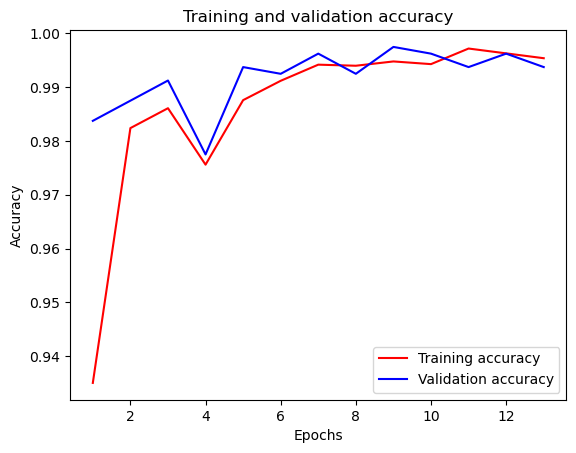

In [16]:
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=50,
    callbacks=[earlystopping]
)

# Plot the training and validation accuracy for each epoch
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, 'red', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The graph shows that our early stopping function stopped the model after 13 epochs and it shows that the train and validation accuracy progressed similarly as the training proceeded with the number of epochs increasing. I dont think we would need to make any modifications to this as this does not show excessive signs of either underfitting or overfitting.

Now, we will take 10 images from the test dataset; we will visualise them, write the predictions by the model for them, we will also write their actual labels. Finally, we will print the confusion matrix to assess the performance of our model. 

10/10 [==============================] - 0s 21ms/step
Predicted label: WithoutMask, Actual label: WithMask


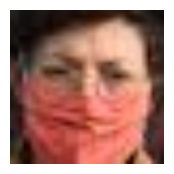

Predicted label: WithMask, Actual label: WithMask


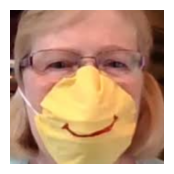

Predicted label: WithMask, Actual label: WithMask


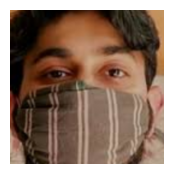

Predicted label: WithMask, Actual label: WithMask


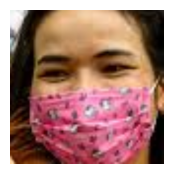

Predicted label: WithMask, Actual label: WithMask


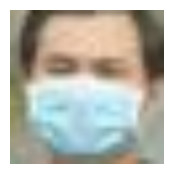

Predicted label: WithMask, Actual label: WithMask


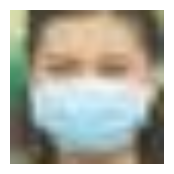

Predicted label: WithMask, Actual label: WithMask


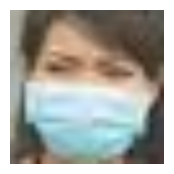

Predicted label: WithMask, Actual label: WithMask


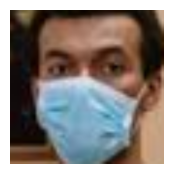

Predicted label: WithMask, Actual label: WithMask


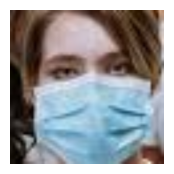

Predicted label: WithMask, Actual label: WithMask


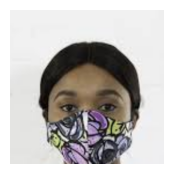

Predicted label: WithMask, Actual label: WithMask


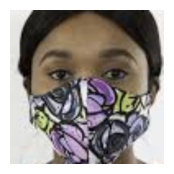

Predicted label: WithMask, Actual label: WithMask


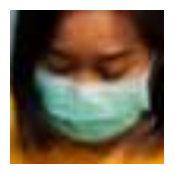

Predicted label: WithMask, Actual label: WithMask


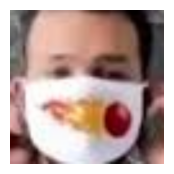

Predicted label: WithMask, Actual label: WithMask


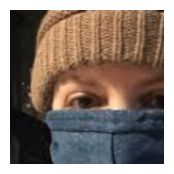

Predicted label: WithMask, Actual label: WithMask


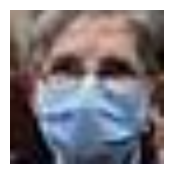

Predicted label: WithMask, Actual label: WithMask


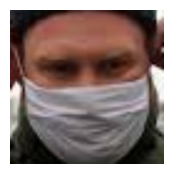

Predicted label: WithMask, Actual label: WithMask


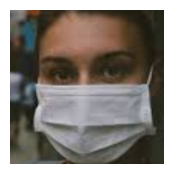

Predicted label: WithMask, Actual label: WithMask


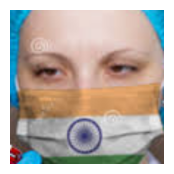

Predicted label: WithMask, Actual label: WithMask


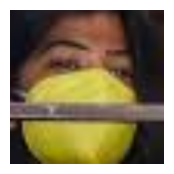

Predicted label: WithMask, Actual label: WithMask


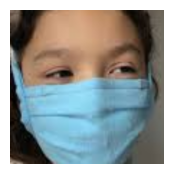

Predicted label: WithMask, Actual label: WithMask


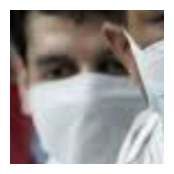

Predicted label: WithMask, Actual label: WithMask


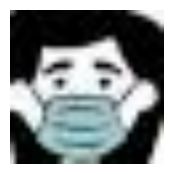

Predicted label: WithMask, Actual label: WithMask


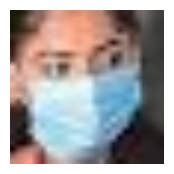

Predicted label: WithMask, Actual label: WithMask


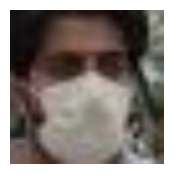

Predicted label: WithMask, Actual label: WithMask


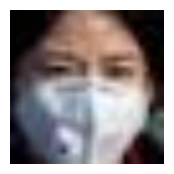

Predicted label: WithMask, Actual label: WithMask


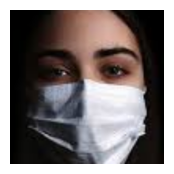

Predicted label: WithMask, Actual label: WithMask


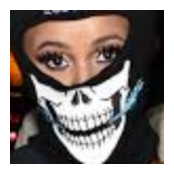

Predicted label: WithMask, Actual label: WithMask


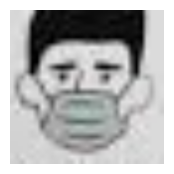

Predicted label: WithMask, Actual label: WithMask


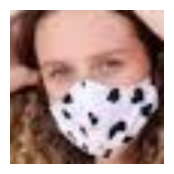

Predicted label: WithMask, Actual label: WithMask


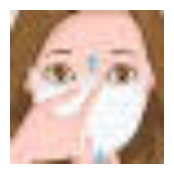

31/31 [==============================] - 3s 98ms/step - loss: 0.0470 - accuracy: 0.9879
Test accuracy: 0.9879032373428345
31/31 [==============================] - 2s 58ms/step
[[476   7]
 [  5 504]]


In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Take the first 30 images from the test dataset
test_images = []
test_labels = []
class_names = test_ds.class_names

for images, labels in test_ds.take(10):
    for image in images:
        test_images.append(image.numpy())
    for label in labels:
        test_labels.append(label.numpy())

test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Make predictions on the images using the model
predictions = model.predict(test_images)

# Print the predicted label and actual label for each image
for i in range(30):
    predicted_label = class_names[np.argmax(predictions[i])]
    actual_label = class_names[test_labels[i]]
    print(f"Predicted label: {predicted_label}, Actual label: {actual_label}")

    # Visualize the image
    plt.figure(figsize=(2,2))
    plt.imshow(test_images[i].astype("uint8"))
    plt.axis('off')
    plt.show()

# Print the confusion matrix for the test dataset
test_loss, test_acc = model.evaluate(test_ds)
print("Test accuracy:", test_acc)

test_labels = np.array([label.numpy() for _, label in test_ds.map(lambda x, y: (x, y)).unbatch()])
predictions = np.argmax(model.predict(test_ds), axis=1)
cm = confusion_matrix(test_labels, predictions, labels=np.arange(len(class_names)))
print(cm)

In this case, the matrix is [[476 7], [5 504]]. This means that the model correctly predicted 476 samples as belonging to the first class ie images 'withMask', and incorrectly predicted 7 samples from the first class ie images 'withMask' as belonging to the second class ie images 'withoutMask'. Similarly, the model correctly predicted 504 samples as belonging to the second class ie images 'withoutMask', and incorrectly predicted 5 samples from the second class as belonging to the first class ie images 'withMask'. Overall, the model seems to be performing well on the test set, as the number of misclassifications is relatively small compared to the total number of samples. The accuracy is also good ie 98.79%

Now, we will print the confusion matrix for the validation set.

In [18]:
# Extract the images and labels from the validation dataset
val_images = []
val_labels = []

for images, labels in validation_ds:
    for image in images:
        val_images.append(image.numpy())
    for label in labels:
        val_labels.append(label.numpy())

val_images = np.array(val_images)
val_labels = np.array(val_labels)

# Make predictions on the images using the model
predictions = model.predict(val_images)

# Print the confusion matrix for the validation dataset
val_labels = np.array([label.numpy() for _, label in validation_ds.map(lambda x, y: (x, y)).unbatch()])
predictions = np.argmax(model.predict(validation_ds), axis=1)
cm = confusion_matrix(val_labels, predictions, labels=np.arange(len(class_names)))
print(cm)

25/25 [==============================] - 1s 17ms/step
[[398   2]
 [  1 399]]


In this case, the matrix is [[398 2], [1 399]]. This means that the model correctly predicted 398 samples as belonging to the first class ie images 'withMask', and incorrectly predicted 2 samples from the first class ie images 'withMask' as belonging to the second class ie images 'withoutMask'. Similarly, the model correctly predicted 399 samples as belonging to the second class ie images 'withoutMask', and incorrectly predicted only 1 sample from the second class as belonging to the first class ie images 'withMask'. Overall, the model seems to be performing well on the validation set, as the number of misclassifications is relatively small compared to the total number of samples. 